<a href="https://colab.research.google.com/github/DeeS17/clustering_ttest_dashboard/blob/main/sprint_12_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Content
- Stage 1: Data Pre-processing
  - Load Data
  - Data Quality Checking
  - Data Cleaning
    - Check & Handle Duplicate Data
    - Missing Values in Description Column
    - Zero and Negative Values in Column Quantity and Unit Price
    - Missing Values in CustomerID Column
  - Adjust Data Type
- Stage 2: Exploratory Data Analysis
  - Revenue Trend per Month
  - Average Purchase Size Trend per Month
  - Month-to-month Trends in Average Revenue per User
  - Customer Segmentation
    - Create Cluster of Segmentation
    - Segments Tend to Make Several Orders Over a Long Period of Time
    - Segments Make Many Purchases Over a Short Period of Time
    - Segments Tend to Make Big Orders
    - Pattern of Consumption
    - Revenue by Segments
- Stage 3: Hypothesis Testing
- Stage 4: Conclusion 
- Stage 5: Recommendation

# Introduction

The dataset contains the transaction history of Everything Plus, an online store that sells household goods that want to identify consumer profiles.

# Objective

- Segment users based on their consumer profiles.
- Find differences in average order frequency and size between user segments. 

# Stages
- Data Pre-processing
- Exploratory Data Analysis
- Hypothesis Testing
- Conclusion
- Recommendation

# Data Pre-processing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from operator import attrgetter
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import ttest_ind

import warnings
warnings.filterwarnings("ignore")

## Load Data

In [ ]:
try:
  df = pd.read_csv('/content/ecommerce_dataset_us.csv', sep='\t')
except:
  df = pd.read_csv('/datasets/ecommerce_dataset_us.csv', sep='\t')

## Data Quality Checking

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 28.9+ MB


There are several columns whose data type needs to be adjusted, here are the columns:
- `InvoiceDate` column should be `Datetime`.
- `CustomerID` column should be `integer`.  

Because there is still missing data, the data type adjustment will be made after the missing data is handled.

In [ ]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
dtype: int64

There are two columns that have missing data. These columns are:
- `Description` which missing `1,454` rows of data.
- `CustomerID` which missing `135,080` rows of data.

I will handle in next step.

## Data Cleaning

### Check & Handle Duplicate Data

In [ ]:
df.duplicated().sum()

5268

There are `5,268` duplicate data. therefore I will deal with the duplicate data.

In [ ]:
df_ = df.drop_duplicates()
df_.duplicated().sum()

0

The duplicate data is already clear.

### Missing Values in Description Column

In [ ]:
df_1 = df_.dropna(subset=['Description'])
df_1['Description'].isna().sum()

0

I `drop` the missing data in the `Description` column. Due to the amount of data (`1,454`), the proportion is not too large compared to the entire dataset. Now the missing data in `Description` column already clear. I differentiate the dataset name. The goal is that the missing data in the `Description` column can still be accessed if needed.

### Zero and Negative Values in Column Quantity and Unit Price

In [ ]:
df_1.loc[df_1['Quantity'] <= 0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
141,C536379,D,Discount,-1,11/29/2018 09:41,27.50,14527.0
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,11/29/2018 09:49,4.65,15311.0
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,11/29/2018 10:24,1.65,17548.0
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,11/29/2018 10:24,0.29,17548.0
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,11/29/2018 10:24,0.29,17548.0


In [ ]:
df_1.loc[df_1['UnitPrice'] <= 0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
6391,536941,22734,amazon,20,12/01/2018 12:08,0.0,NaN
6392,536942,22139,amazon,15,12/01/2018 12:08,0.0,NaN
7313,537032,21275,?,-30,12/01/2018 16:50,0.0,NaN
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,12/03/2018 14:02,0.0,12647.0
13217,537425,84968F,check,-20,12/04/2018 15:35,0.0,NaN


From the data shown above, the zero and negative values in the `Quantity` and `UnitPrice` columns seem to be for adjustments in case of missing items, discounts, or order cancellations. Because the data is not used in the analysis of customer buying behavior, I will remove this data. The filtered dataset will be saved under a different name. So that if the values are zero and negative in the `quantity` and `UnitPrice` columns they can still be accessed if needed.

In [ ]:
df_2 = df_1.loc[(df_1['Quantity'] > 0)].copy()

In [ ]:
df_2.loc[df_2['Quantity'] <= 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID


In [ ]:
df_2 = df_2.loc[(df_2['UnitPrice'] > 0)].copy()

In [ ]:
df_2.loc[df_2['UnitPrice'] <= 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID


Zeros and negative values in the `Quantity` and `UnitPrice` columns have been cleared.

### Missing Values in CustomerID Column

In [ ]:
df_3 = df_2.dropna(subset=['CustomerID'])
df_3['Description'].isna().sum()

0

In [ ]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392692 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    392692 non-null  object 
 1   StockCode    392692 non-null  object 
 2   Description  392692 non-null  object 
 3   Quantity     392692 non-null  int64  
 4   InvoiceDate  392692 non-null  object 
 5   UnitPrice    392692 non-null  float64
 6   CustomerID   392692 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 24.0+ MB


Missing values in column `CustomerID` have been successfully cleaned up. The missing values in the `CustomerID` column are numerous (`132,186`) and a large proportion of the entire dataset. However, these missing values need to be removed because in analyzing customer behavior a `CustomerID` column is needed. However, the cleaned dataset is stored under a different name. So that if data is lost in the `CustomerID` column it can still be accessed if needed.

## Adjust Data Type

Now the dataset already clean of missing values, so I will adjust column `InvoiceDate` and `CustomerID`.

In [ ]:
df_3['InvoiceDate'] = pd.to_datetime(df_3['InvoiceDate'])
df_3['CustomerID'] = df_3['CustomerID'].astype('int64')
df_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392692 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392692 non-null  object        
 1   StockCode    392692 non-null  object        
 2   Description  392692 non-null  object        
 3   Quantity     392692 non-null  int64         
 4   InvoiceDate  392692 non-null  datetime64[ns]
 5   UnitPrice    392692 non-null  float64       
 6   CustomerID   392692 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 24.0+ MB


Now the type of data already fits and is clean of missing values.  

# Exploratory Data Analysis

## Revenue Trend per Month

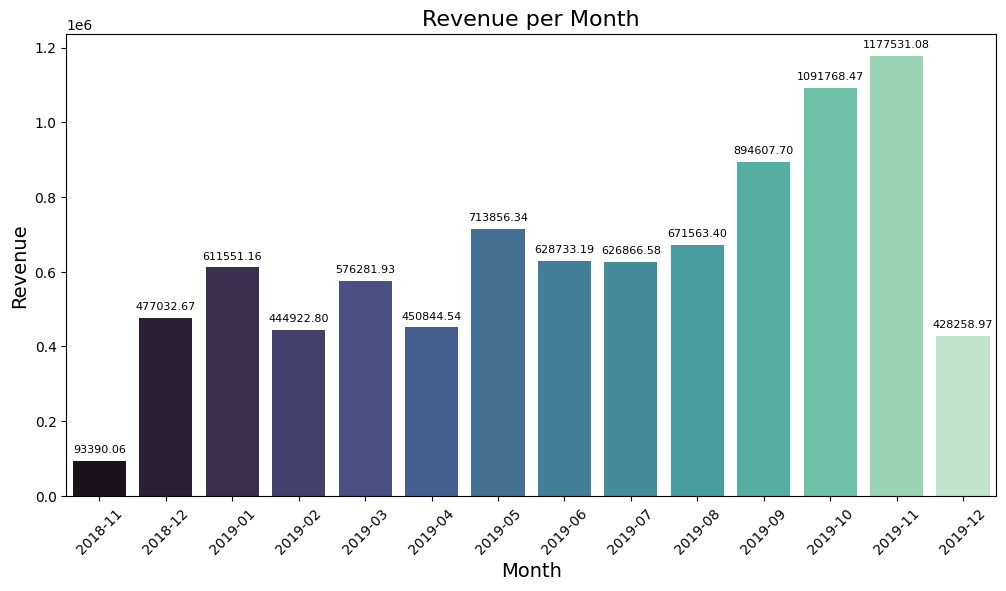

In [ ]:
# Add column subtotal and month of invoice
df_3['sub_total'] = df_3['Quantity'] * df_3['UnitPrice']
df_3['invoice_m'] = df_3['InvoiceDate'].dt.to_period('M')

# create dataset revenue per month
rev_per_m = df_3.groupby('invoice_m').agg({'sub_total':'sum'}).reset_index()
rev_per_m.columns = ['month', 'revenue']

# create a barplot
fig, ax = plt.subplots(figsize=(12, 6))
plots = sns.barplot(data=rev_per_m, x='month', y='revenue', ax=ax, palette='mako')

for bar in plots.patches:
   
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')
    
plt.xticks(rotation=45)    
plt.title('Revenue per Month', size=16)
plt.xlabel('Month', size=14)
plt.ylabel('Revenue', size=14)
plt.show()

In [ ]:
# Minimum and maximum value of invoice date
df_3['InvoiceDate'].min(), df_3['InvoiceDate'].max()

(Timestamp('2018-11-29 08:26:00'), Timestamp('2019-12-07 12:50:00'))

November 2018 and December 2019 are relatively small compared to other months because they are fully recorded. November 2018 was start recorded on the 29th, while December 2019 was only recorded until the 7th.

In 2019, the income trend tends to be higher in semester 2, especially in September, October, and November. In those three months, his income increased dramatically.

## Average Purchase Size Trend per Month

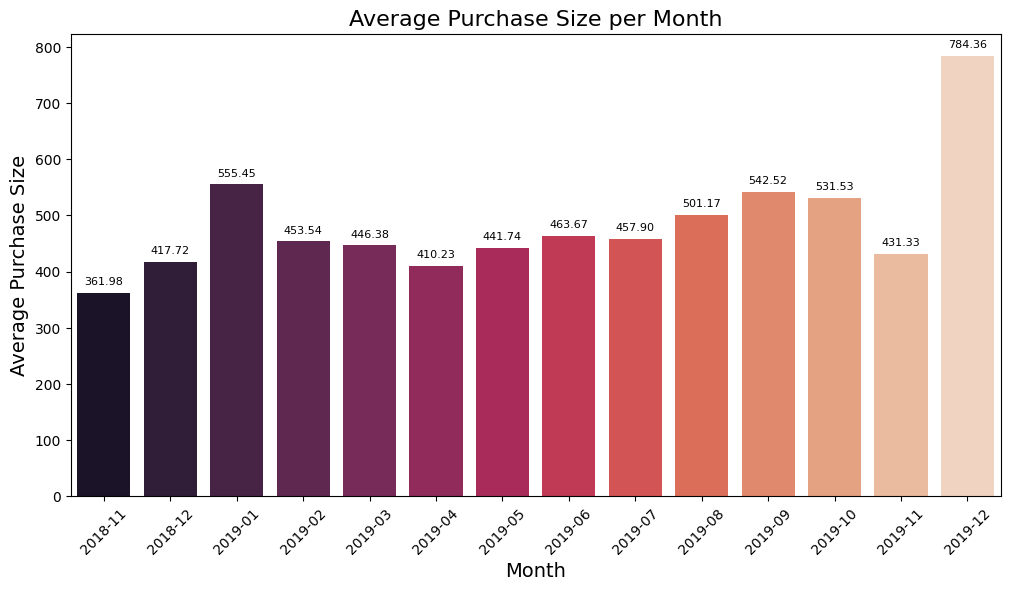

In [ ]:
# Create dataset of average purchase / order size per month
purc_size = df_3.groupby(['invoice_m', 'InvoiceNo']).agg({'sub_total':'sum'}).reset_index()
avg_purc_sz_by_m = purc_size.groupby('invoice_m').agg({'sub_total':'mean'})
avg_purc_sz_by_m.reset_index(inplace=True)
avg_purc_sz_by_m.columns = ['month', 'avg_purchase_size_per_month']


#create barplot
fig, ax = plt.subplots(figsize=(12, 6))
plots = sns.barplot(data=avg_purc_sz_by_m, x='month', y='avg_purchase_size_per_month', ax=ax, palette='rocket')

for bar in plots.patches:
   
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')
    
plt.xticks(rotation=45)    
plt.title('Average Purchase Size per Month', size=16)
plt.xlabel('Month', size=14)
plt.ylabel('Average Purchase Size', size=14)
plt.show()

In [ ]:
# minimum and maximum revenue purchase / order size per month
avg_purc_sz_by_m['avg_purchase_size_per_month'].min(), avg_purc_sz_by_m['avg_purchase_size_per_month'].max()

(361.97697674418606, 784.357087912088)

The highest `Average Purchase Size` occurred in December 2019, with a value of `784.36`. Meanwhile, the lowest `Average Purchase Size` occurred in November 2018 with a value of `361.98`.

In the second half, there was no significant increase as seen in the `revenue` chart. This means that the increase in `revenue` is not due to an increase in `purchase size`, but because of an increase in the number of orders.

## Month-to-month Trends in Average Revenue per User

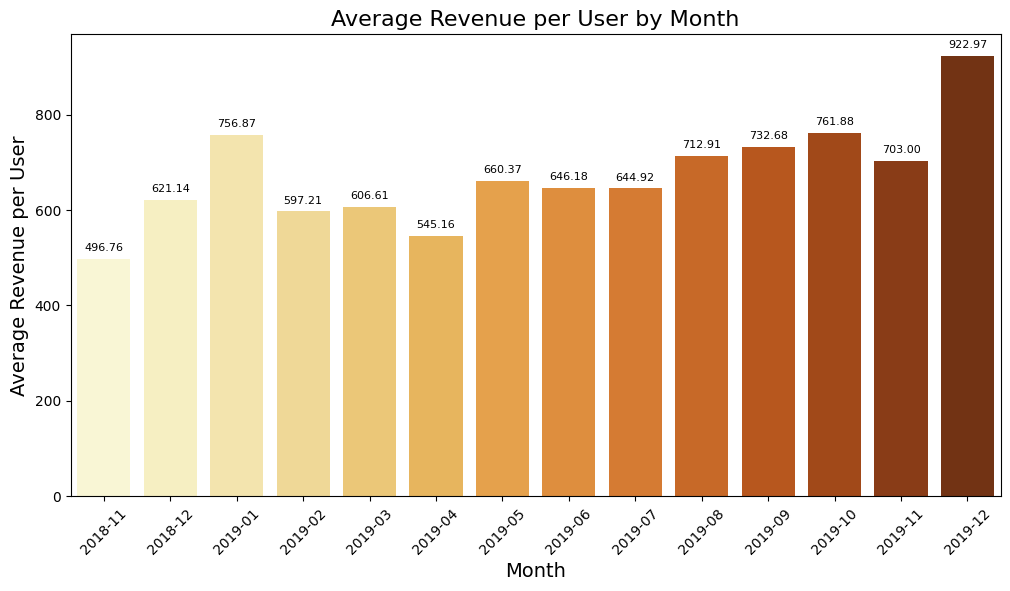

In [ ]:
#create dataset average revenue per user by month
rev_per_user_per_m = df_3.groupby(['invoice_m', 'CustomerID']).agg({'sub_total':'sum'}).reset_index()
avg_rev_per_user_by_m = rev_per_user_per_m.groupby('invoice_m').agg({'sub_total':'mean'}).reset_index()
avg_rev_per_user_by_m.columns = ['month', 'avg_rev_per_user']

# create barplot
fig, ax = plt.subplots(figsize=(12, 6))
plots = sns.barplot(data=avg_rev_per_user_by_m, x='month', y='avg_rev_per_user', ax=ax, palette='YlOrBr')

for bar in plots.patches:
   
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')
    
plt.xticks(rotation=45)    
plt.title('Average Revenue per User by Month', size=16)
plt.xlabel('Month', size=14)
plt.ylabel('Average Revenue per User', size=14)
plt.show()

In [ ]:
# minimum and maximum average revenue per user
avg_rev_per_user_by_m['avg_rev_per_user'].min(), avg_rev_per_user_by_m['avg_rev_per_user'].max()

(496.75563829787234, 922.9719181034484)

The highest `Average Revenue per User` occurred in December 2019, with a value of `922.97`. Meanwhile, the lowest occurred in November 2018 with a value of `496.76`. This finding is quite similar to `Average Purchase Size per Month`.

In the second half, there was no significant increase as seen in the `revenue` chart. This means that the increase in `revenue` is not due to an increase in `Average Revenue per User`, but because of an increase in the number of orders or customer.

## Customer Segmentation

### Create Cluster of Segmentation

In [ ]:
#Create Customer Profile
cust_per_inv = df_3.groupby(['CustomerID','InvoiceNo']).agg({'StockCode':'nunique', 'Quantity':'sum', 'sub_total':'sum', 'invoice_m':'min'}).reset_index()
cust_per_inv['invoice_m_1'] = cust_per_inv['invoice_m']

cust_profile = cust_per_inv.groupby('CustomerID').agg({'InvoiceNo':'nunique', 
                                                       'StockCode':'sum', 
                                                       'Quantity': 'sum',
                                                       'sub_total':'sum',
                                                       'invoice_m':'min',
                                                       'invoice_m_1':'max'})

cust_profile.reset_index(inplace=True)
cust_profile.columns = ['CustomerID', 'inv_num', 'item_var', 'qty', 'revenue', 'first_buy_m', 'last_buy_m']

cust_profile['buy_period_m'] = cust_profile['last_buy_m'] - cust_profile['first_buy_m']
cust_profile['buy_period_m'] = cust_profile['buy_period_m'].apply(attrgetter('n'))
cust_profile['avg_price_qty'] = cust_profile['revenue'] / cust_profile['qty']

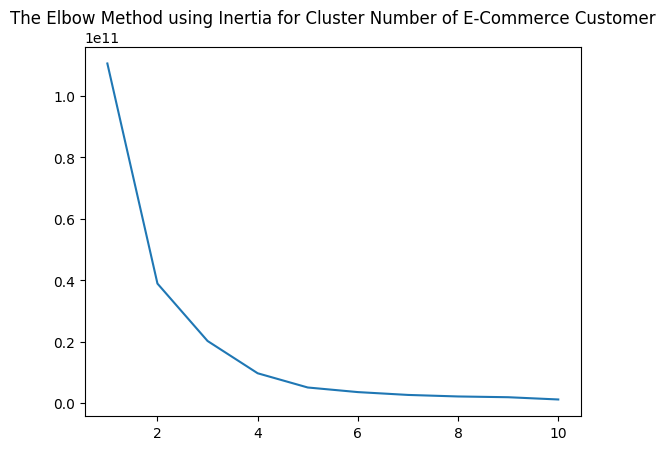

In [ ]:
#Finding Cluster Number of E-Commerce Customer using Elbow Method
X = cust_profile.drop(['CustomerID', 'first_buy_m', 'last_buy_m', 'revenue'], axis=1)

cluster = []
wcss = []
for i in range(10):
    km = KMeans(n_clusters=i+1, n_init='auto', random_state=4)
    km.fit(X)
    error = km.inertia_
    wcss.append(error)
    cluster.append(i+1)

plt.plot(cluster, wcss)
plt.title('The Elbow Method using Inertia for Cluster Number of E-Commerce Customer')
plt.show()

According to the line plot of the elbow method, the cluster number of e-commerce customers suggested `3 clusters`.

In [ ]:
# Put the Segment into The Dataset
scaler = StandardScaler()
X_sc = scaler.fit_transform(X)

km = KMeans(n_clusters = 3, n_init='auto', random_state=4)
clusters = km.fit_predict(X_sc)
cust_profile['segment'] = clusters

In [ ]:
cust_profile['segment'].unique()

array([0, 2, 1], dtype=int32)

All `3 clusters` have been implemented in the dataset.

In [ ]:
cust_profile.groupby('segment').agg({'CustomerID':'count'})

,CustomerID
segment,
0,1582
1,1
2,2755


In [ ]:
cust_profile.loc[cust_profile['segment'] == 1]

,CustomerID,inv_num,item_var,qty,revenue,first_buy_m,last_buy_m,buy_period_m,avg_price_qty,segment
4013,17846,1,1,1,2033.1,2019-09,2019-09,0,2033.1,1


The number of `segment 1` turned out to be only 1 customer. After checking the data, it turns out that this customer has a very unique purchase pattern from other customers and transactions.

That customer is the only customer who has one transaction and one item, but the item's value is `2,033.1`. It is the highest item value per quantity than other customers. So when comparing data between `segments`, I would not include `segment 1` in the analysis.

### Segments Tend to Make Seasonal Purchases

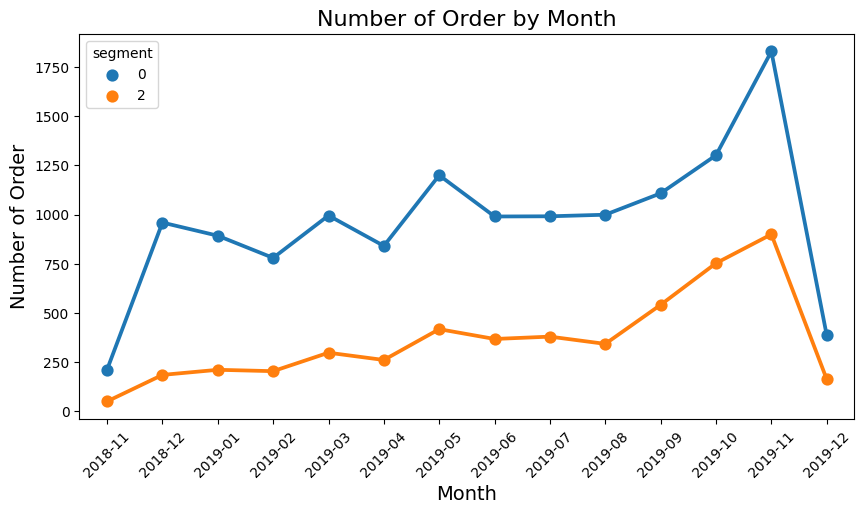

In [ ]:
# dictionary of Customer ID and it's segment
cust_ID_segment_dict = cust_profile[['CustomerID', 'segment']]

# create dataset number of order for every segment by month
cust_per_inv2 = cust_per_inv.merge(cust_ID_segment_dict, how='left', on='CustomerID')
cust_per_inv2.drop('invoice_m_1', axis=1, inplace=True)
cust_per_inv2.columns = ['CustomerID', 'InvoiceNo', 'item_var', 'Quantity', 'sub_total', 'invoice_m', 'segment']
month_segment_num_inv = cust_per_inv2.groupby(['invoice_m', 'segment']).agg({'InvoiceNo':'nunique'}).reset_index()
month_segment_num_inv.columns = ['month', 'segment', 'num_of_order']
month_segment_num_inv = month_segment_num_inv.loc[ month_segment_num_inv['segment'] != 1]

fig, ax = plt.subplots(figsize=(10, 5))
sns.pointplot(data=month_segment_num_inv, x='month', y='num_of_order', hue='segment', ax=ax)
plt.xticks(rotation=45)    
plt.title('Number of Order by Month', size=16)
plt.xlabel('Month', size=14)
plt.ylabel('Number of Order', size=14)
plt.show()

The similarity of the order trend between `segments 0` and `2` is that there has been an increase from `September 2019` to `November 2019`. The difference is in `2018` in `segment 0` there was a drastic increase in `December`, but did not happen in `segment 2`. Also, in the first half of `2019`, `segment 0` was more volatile than `segment 2.

There's also something else that I didn't expect. It turns out that the number of orders of `segment 0` is more than `segment 2`, while the number of `customers` of `segment 2` is more than `segment 0`.

### Segments Tend to Make Several Orders Over a Long Period of Time

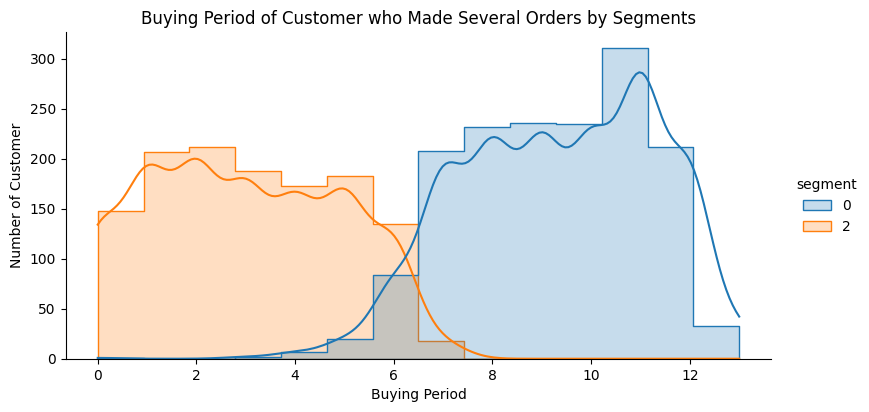

In [ ]:
# filter only customer who made several order
cust_profile_several_order = cust_profile.loc[cust_profile['inv_num'] > 1].copy()

# create barplot
sns.displot(cust_profile_several_order, x='buy_period_m', hue='segment', element='step', kde=True, height=4, aspect=2, palette='tab10')
plt.title('Buying Period of Customer who Made Several Orders by Segments', size=12)
plt.xlabel('Buying Period', size=10)
plt.ylabel('Number of Customer', size=10)
plt.show()

The visualization above shows that `segment 0` customers tend to have a longer buying period. Buying period for `segment 2` customers is between 0 - 6 months, while `segment 0` is between 6 - 12 months.

This means that customer `segment 0` has a higher probability of generating income for the company. Because a longer purchase period provides a higher chance of more orders.

This might explain why `segment 0` has more orders, even though it has fewer customers.

### Segments Make Many Purchases Over a Short Period of Time

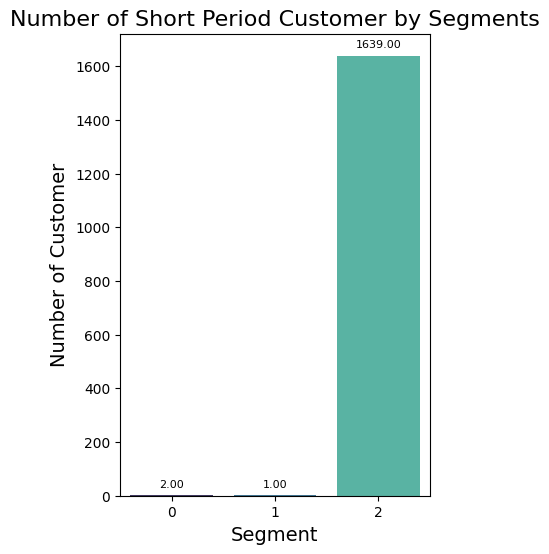

In [ ]:
# filter only customer who order in short period
cust_profile_short_period = cust_profile.loc[cust_profile['buy_period_m'] < 1].copy()

# create dataset of number of customer by segment
short_period_segment = cust_profile_short_period.groupby('segment').agg({'CustomerID':'count'}).reset_index()
short_period_segment.columns = ['segment', 'cust_num']

# create barplot
fig, ax = plt.subplots(figsize=(4, 6))
plots = sns.barplot(data=short_period_segment, x='segment', y='cust_num', ax=ax, palette='mako')

for bar in plots.patches:
   
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')
     
plt.title('Number of Short Period Customer by Segments', size=16)
plt.xlabel('Segment', size=14)
plt.ylabel('Number of Customer', size=14)
plt.show()

The graph above shows that almost all customers who have a short purchase period (1 month and below) come from `segment 2`. The number of short purchase period customers in `segment 2` is more than half of the total `segment 2` customer population.

### Segments Tend to Make Big Orders

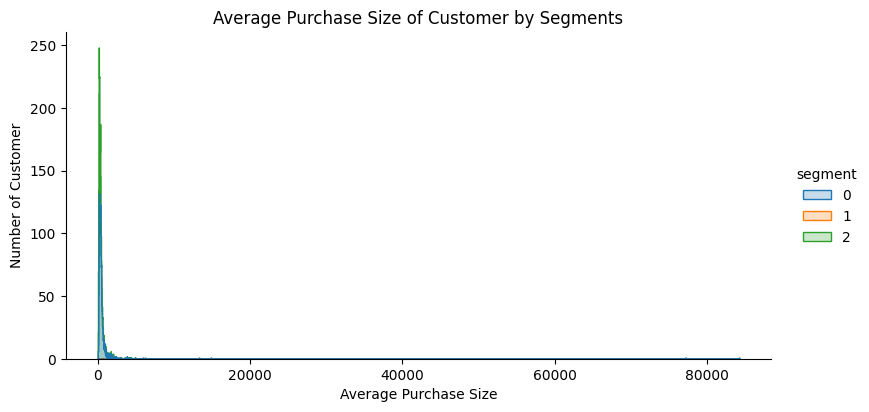

In [ ]:
# add purchase size column in Dataset
cust_profile['av_purc_sz'] = cust_profile['revenue'] / cust_profile['inv_num']

# create barplot
sns.displot(cust_profile, x='av_purc_sz', hue='segment', element='step', height=4, aspect=2, palette='tab10')
plt.title('Average Purchase Size of Customer by Segments', size=12)
plt.xlabel('Average Purchase Size', size=10)
plt.ylabel('Number of Customer', size=10)
plt.show()

The `Average Purchase Size` range is very wide, so I will narrow the chart display limit for a better view.

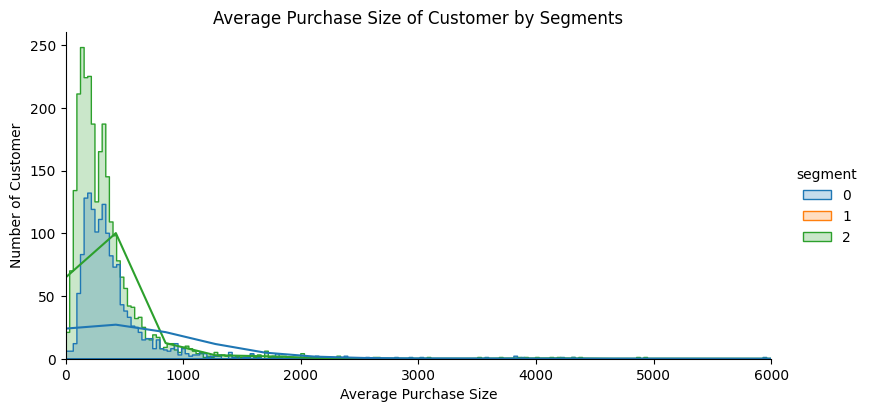

In [ ]:
# adjust barplot
sns.displot(cust_profile, x='av_purc_sz', hue='segment', element='step', kde=True, height=4, aspect=2, palette='tab10')
plt.title('Average Purchase Size of Customer by Segments', size=12)
plt.xlabel('Average Purchase Size', size=10)
plt.ylabel('Number of Customer', size=10)
plt.xlim([0, 6000])
plt.show()

The graph shows most of the data distribution of `average purchase size` in both segments ranging from 0 - 1,000. In the range 0 - 1,000, `segment 2` customers are more dense than `segment 0`. Otherwise, the density of `segment 0` customers is more spread to higher values. In addition, the `average purchase size` above 1,000 seems to be categorized as `outliers`. I will confirm this later using `boxplot`.

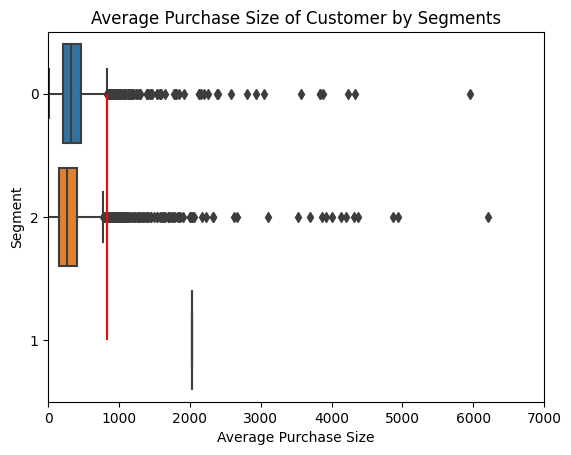

In [ ]:
cust_profile_b_plot = cust_profile.copy()
cust_profile_b_plot['segment'] = cust_profile_b_plot['segment'].astype('str')
sns.boxplot(data=cust_profile_b_plot, x="av_purc_sz", y="segment")

plt.title('Average Purchase Size of Customer by Segments', size=12)
plt.xlabel('Average Purchase Size', size=10)
plt.ylabel('Segment', size=10)
plt.xlim([0, 7000])
plt.vlines(830, 0, 2, colors='red')
plt.show()

In [ ]:
cust_profile_b_plot.loc[cust_profile_b_plot['av_purc_sz'] > 800].groupby('segment')['CustomerID'].count()

segment
0    123
1      1
2    167
Name: CustomerID, dtype: int64

The `boxplot` shows the limits of the `upper whisker` in `segment 0` and `segment 2` around `800`. This means that customers with an `average purchase size` value above `800` are categorized as `outliers`. In `segment 0` there are `123` customers, `segment 1` has `1` customers, and `segment 2` has `167` customers.

### Pattern of Consumption

In [ ]:
# function to find highest upper whisker betweeen segment 0 & 2

def find_Q3(values_array):
  return values_array.describe()['75%']

def find_IQR(values_array):
  return find_Q3(values_array) - values_array.describe()['25%']

def find_upper_whisker (column, dataset) :
  dataset_0 = dataset.loc[dataset['segment'] == 0]
  dataset_2 = dataset.loc[dataset['segment'] == 2]
  upper_whisker_0 = find_Q3(dataset_0[column]) + find_IQR(dataset_0[column])*1.5
  upper_whisker_2 = find_Q3(dataset_2[column]) + find_IQR(dataset_2[column])*1.5

  if upper_whisker_0 > upper_whisker_2 :
    return upper_whisker_0
  else :
    return upper_whisker_2

In [ ]:
cust_profile.columns.drop(['CustomerID', 'revenue', 'first_buy_m', 'last_buy_m', 'segment'])

Index(['inv_num', 'item_var', 'qty', 'buy_period_m', 'avg_price_qty',
       'av_purc_sz'],
      dtype='object')

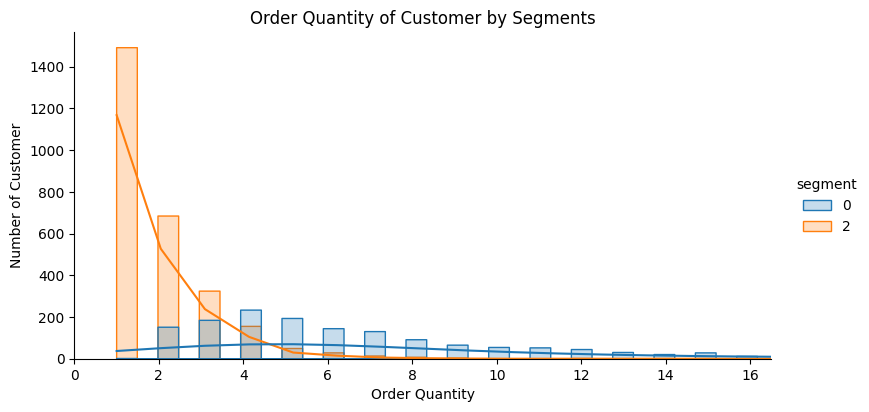

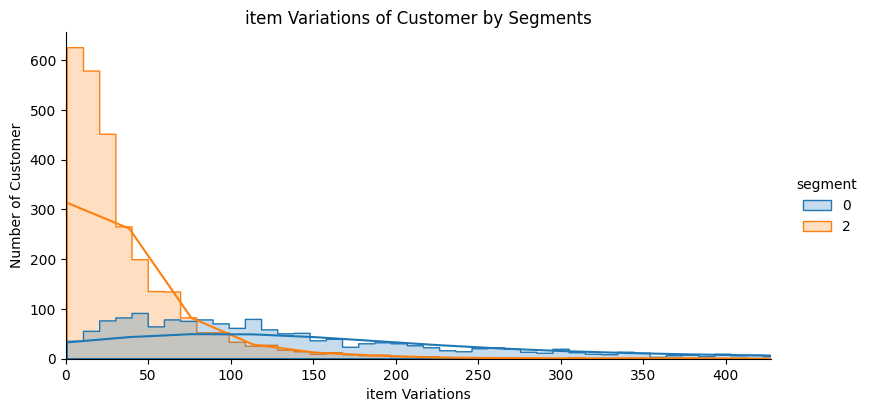

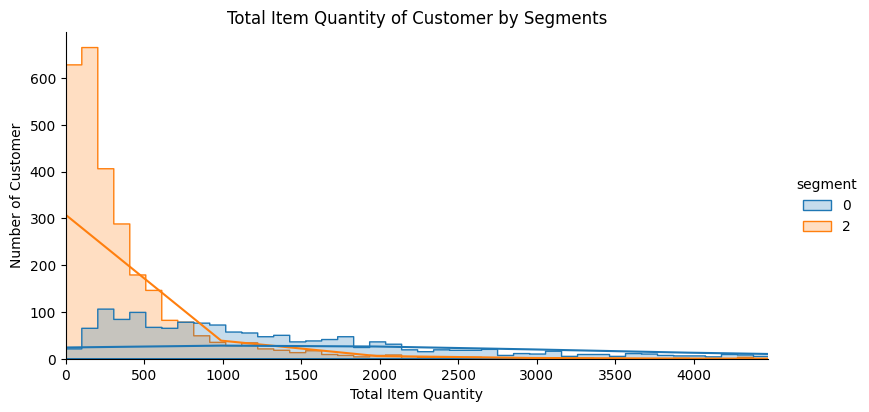

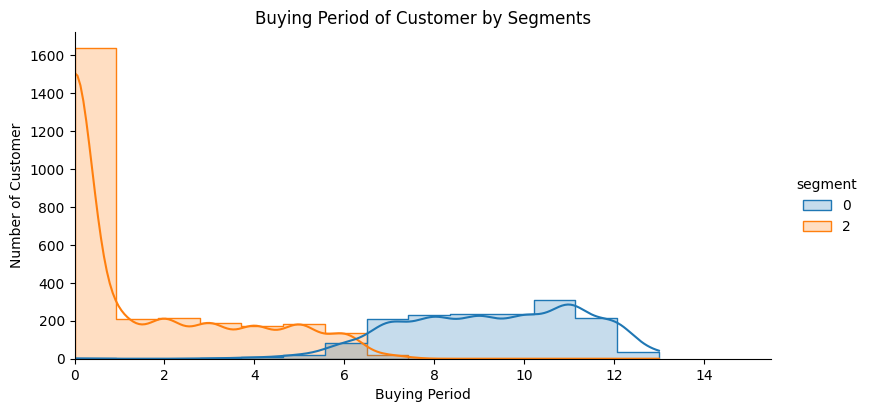

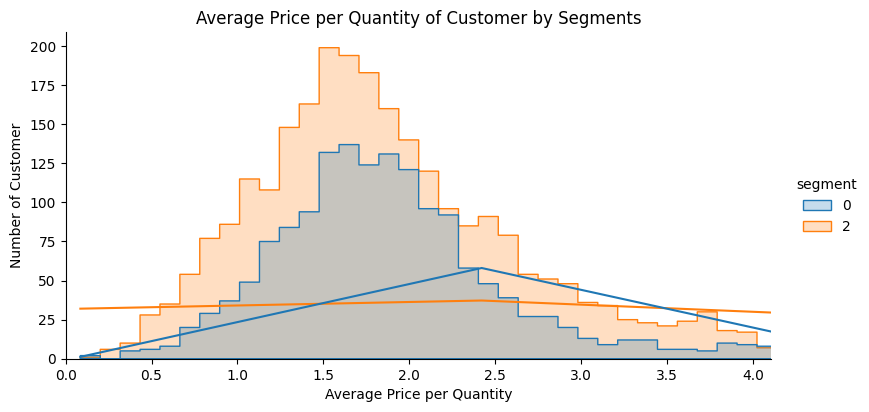

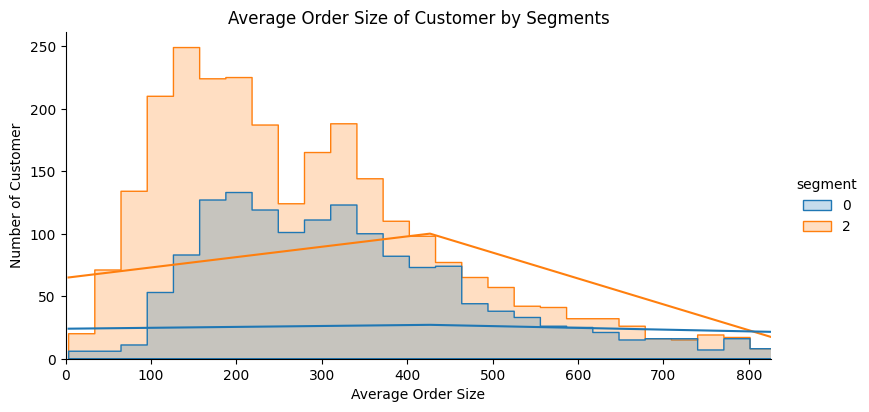

In [ ]:
for col in cust_profile.columns.drop(['CustomerID', 'revenue', 'first_buy_m', 'last_buy_m', 'segment']) :
  #filter segment 1, because only have 1 customer
  cust_profile_wo_1 = cust_profile.loc[cust_profile['segment'] != 1]
  

  if col == 'inv_num':
    title_text = 'Order Quantity'
  elif col == 'item_var':
    title_text = 'item Variations'
  elif col == 'qty':
    title_text = 'Total Item Quantity'
  elif col == 'buy_period_m':
    title_text = 'Buying Period'
  elif col == 'avg_price_qty':
    title_text = 'Average Price per Quantity'
  elif col == 'av_purc_sz':
    title_text = 'Average Order Size'

  sns.displot(cust_profile_wo_1, x=col, hue='segment', element='step', kde=True,  height=4, aspect=2, palette='tab10')
  # limit the highest upper whisker, to make better view of visualization
  plt.xlim([0,find_upper_whisker(col, cust_profile_wo_1)])
  plt.title(title_text + ' of Customer by Segments', size=12)
  plt.ylabel('Number of Customer', size=10)
  plt.xlabel(title_text, size=10)
  plt.show()

Based on all graphs above, the consumption pattern of customers in `segment 0` tend to have higher `Order Quantity`, `Item Variations`, `Total Item Quantity`, and `Buying Period`. Otherwise `Average Price per Qty` and `Average Order Size` between `segment 0` and `segment 2` are look quite similar. 

### Revenue by Segments

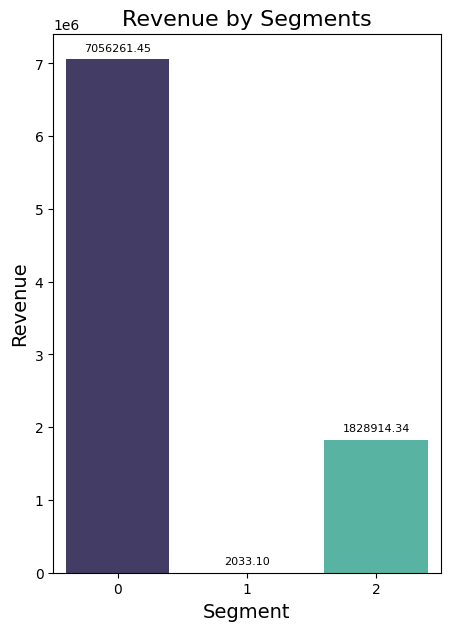

In [ ]:
# data of revenue by segments
rev_by_segments = cust_profile.groupby('segment')['revenue'].sum().reset_index()

# create barplot
fig, ax = plt.subplots(figsize=(5, 7))
plots = sns.barplot(data=rev_by_segments, x='segment', y='revenue', ax=ax, palette='mako')

for bar in plots.patches:
   
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')
     
plt.title('Revenue by Segments', size=16)
plt.xlabel('Segment', size=14)
plt.ylabel('Revenue', size=14)
plt.show()

Even `segment 2` have more customers, customers in `segment 0` contribute more `revenue` to the company. This finding gives insight that loyal customers with repeat orders over a long time are more matter than the number of customers.  

# Hypothesis Testing

In [ ]:
#Seperate dataset into 2 sample (segment 0 and segment 2)
cust_profile_0 = cust_profile.loc[cust_profile['segment'] == 0].copy()
cust_profile_2 = cust_profile.loc[cust_profile['segment'] == 2].copy()

In [ ]:
# Function of to test 2 independent sample
def h_test_2_ind(samp_seg_0, samp_seg_2, column, alpha) :
    result = ttest_ind(samp_seg_0[column], samp_seg_2[column])
    pval = result.pvalue

    if column == 'inv_num':
      col_text = 'order frequency'
    elif column == 'av_purc_sz':
      col_text = 'order size'
    else:
      return 'Error, wrong column.'
    
    if alpha > pval :
      print('mean of '+ col_text + ' segment 0: ' +str(samp_seg_0[column].mean()))
      print('mean of '+ col_text + ' segment 2: ' +str(samp_seg_2[column].mean()))
      print('The P-Value is: '+ str(pval))
      print ('Reject null hypothesis')
      return
    else :
      print('mean of '+ col_text + ' segment 0: ' +str(samp_seg_0[column].mean()))
      print('mean of '+ col_text + ' segment 2: ' +str(samp_seg_2[column].mean()))
      print('The P-Value is: '+ str(pval))
      print ('Failed to reject null hypothesis')
      return

In this test, I will find out if there is any difference in order size and frequency between `segment 0` and `segment 2`. So before starting, I will define the hypothesis first:
- Order Frequency Hypothesis:
    - H0: There is no difference in orders frequency between user segments.
    - H1: There is a difference in the order frequency between user segments.
- Order Size (Purchase Value/Size) Hypothesis:
  - H0: There is no difference in order size between users segments.
  - H1: There is a difference in order size between user segments. 

In [ ]:
h_test_2_ind(cust_profile_0, cust_profile_2, 'inv_num', 0.05)

mean of order frequency segment 0: 8.52149178255373
mean of order frequency segment 2: 1.8330308529945554
The P-Value is: 2.853534798507145e-183
Reject null hypothesis


So there is a difference in the order frequency between user segments.

In [ ]:
h_test_2_ind(cust_profile_0, cust_profile_2, 'av_purc_sz', 0.05)

mean of order size segment 0: 513.6500320274313
mean of order size segment 2: 361.9309427404719
The P-Value is: 0.007411244877095462
Reject null hypothesis


So there is a difference in the order size between user segments.

This testing finds out customers in `segment 0` significantly have higher values of order size and frequency. So this result enlightens why `segment  0` have higher `revenue` and `number of order`, even though the number of customers is less. Because customers in `segment 0` are more loyal for long periods and made repeat orders, otherwise more than half of customers in `segment 2` buy in short periods and didn't make repeat orders. 

# Conclusion

Based on exploration and hypothesis testing, there are some findings and insights I get and I will share. First, the trend of revenue experienced a drastic increase from `September` to `November 2019`. This increase was caused more by the `number of orders` than the `purchase size` or the `revenue per user`.

next, I will discuss `segmentation`. Basically, there is only 2 `segment`. `segment 0` and `segment 2`. `segment 1` appears because there is 1 very unique customer who only buy one item, once, but the item value is around `2,000`. The number of `segment 0` is almost half of `segment 2` customers. But, `segment 0` revenue contribution to the company 4 times higher than `segment 2`. This happens because the customer in `segment 2` are short-period buy customers. They are not or not yet convert into loyal customer. This graph below will explain more.  

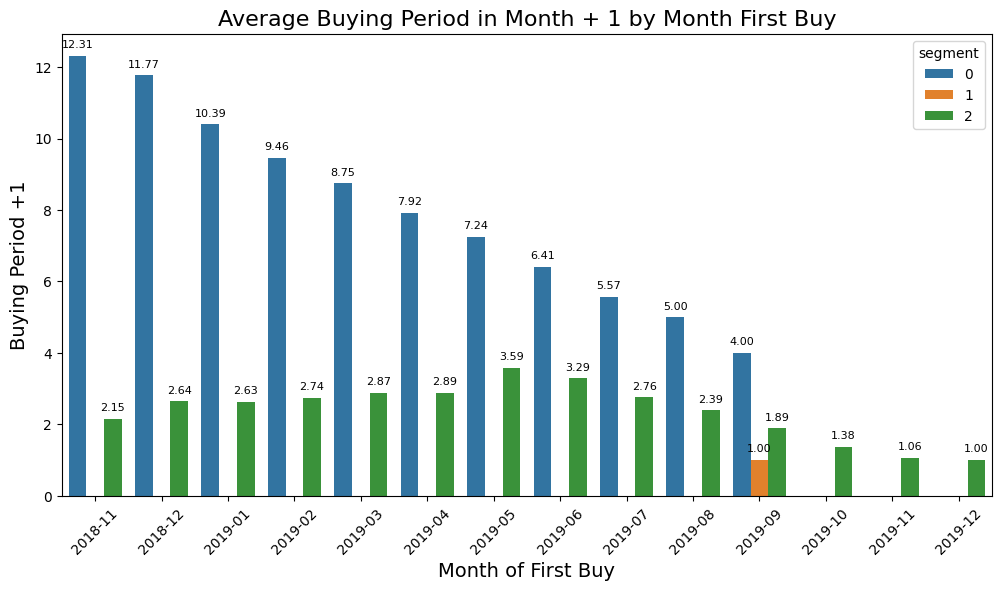

In [ ]:
# create data of first buy month, segment, and buy period
cust_profile['buy_period_m+1'] = cust_profile['buy_period_m'] + 1
avg_period_by_segment = cust_profile.groupby(['first_buy_m', 'segment']).agg({'buy_period_m+1':'mean'}).reset_index()

# create barplot
fig, ax = plt.subplots(figsize=(12, 6))
plots = sns.barplot(data=avg_period_by_segment, x='first_buy_m', y='buy_period_m+1', hue='segment', ax=ax)

for bar in plots.patches:
   
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')

plt.xticks(rotation=45)
plt.title('Average Buying Period in Month + 1 by Month First Buy', size=16)
plt.xlabel('Month of First Buy', size=14)
plt.ylabel('Buying Period +1', size=14)
plt.show()

So the graph above shows `segment 2` customers in every first buy month tend to have shorter buy periods and it confirms many of them do not convert into loyal customers.

The final point is about `revenue`. After all data exploration and hypothesis testing, I find out the number of customers isn't everything. Loyal customers who made repeat orders with higher order sizes give more impact to get higher revenue.

# Recommendation

Because a lot of revenue comes from repeat orders from loyal customers, so I think the company needs to make a loyalty program for customers who made 2 orders in 6 months. Based on data exploratory, customers in `segment 0` minimum have 2 order frequencies and 6 buying periods. So the loyalty program is a reinforcement to convert new customers or short period customers into loyal customers.

For customers `segment 2` who haven't made a new order for more than 2 months. Hopefully, we can contact some of them to make FGD or ask for a feedback survey. the result will give information about why they didn't make a new order or what they are not satisfied with. Based on their information the company will know what needs to be improved. 

# Presentation

Presentation Link:

https://drive.google.com/file/d/1h2GFy4R0THagly2YT8XnGItr7sLyEolk/view?usp=share_link

# Dashboard

Dasehboard Link:

https://public.tableau.com/views/E-CommerceDashboard_16829272932530/Dashboard1?:language=en-GB&publish=yes&:display_count=n&:origin=viz_share_link